In [8]:
import pandas as pd
import numpy as np
import supy as sp
from pathlib import Path
from datetime import datetime

In [16]:
def spin_up(cityname,first_day_str):
    path_runcontrol = Path('../input-processor/pre-processor-UK/runs/run_'+cityname) / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)
    grid = df_state_init.index[0]
    df_forcing = sp.load_forcing_grid(path_runcontrol, grid)
    first_day = datetime.strptime(first_day_str, '%Y-%m-%d')

    print('Rotating the time based on the first day of '+first_day_str)
    first_part = df_forcing.loc[df_forcing[df_forcing.index >= first_day].index]
    second_part = df_forcing.loc[df_forcing[
        df_forcing.index < first_day-pd.Timedelta('1 days')
    ].index]
    second_part.index = second_part.index+pd.Timedelta('366 days')

    df_forcing_2 = first_part.append(second_part)
    df_forcing_2.iy = df_forcing_2.index.year
    df_forcing_2.index.freq = first_part.index.freq
    round_number = 0
    error = 0.4
    counter=0
    while (error >= 0.1 or counter<3):
        counter+=1
        round_number = round_number+1
        print('Running SUEWS for round number '+str(round_number)+'.....')
        df_output, df_state_final = sp.run_supy(
            df_forcing_2, df_state_init,
            save_state=False)
        final_state = df_state_final[df_state_init.columns.levels[0]
                                     ].iloc[1]
        df_state_init.iloc[0] = final_state
        soilstore_before = df_state_final.soilstore_id.iloc[0]
        soilstore_after = df_state_final.soilstore_id.iloc[1]
        diff_soil = sum(abs(soilstore_after-soilstore_before))
        error = 100*diff_soil/soilstore_before.mean()
        print('Change in soil store in % = '+str(error))

    print('SUEWS spinup is finished. Total number of runs = ' + str(round_number))
    
    return df_state_init, df_forcing_2

In [17]:
cityname='London'
first_day_str = '2012-04-10'
df_state_init, df_forcing=spin_up(cityname,first_day_str)

Rotating the time based on the first day of 2012-04-10
Running SUEWS for round number 1.....
Change in soil store in % = 20.34325658575821
Running SUEWS for round number 2.....
Change in soil store in % = 12.929705322136053
Running SUEWS for round number 3.....
Change in soil store in % = 7.697583526269945
Running SUEWS for round number 4.....
Change in soil store in % = 5.3649886035224315
Running SUEWS for round number 5.....
Change in soil store in % = 3.877315889982324
Running SUEWS for round number 6.....
Change in soil store in % = 2.8922842260036794
Running SUEWS for round number 7.....
Change in soil store in % = 2.2058927670312016
Running SUEWS for round number 8.....
Change in soil store in % = 1.707619299917459
Running SUEWS for round number 9.....
Change in soil store in % = 1.3393623511879398
Running SUEWS for round number 10.....
Change in soil store in % = 1.0601441315309024
Running SUEWS for round number 11.....
Change in soil store in % = 0.8455373289264309
Running SUEW

In [18]:
df_output, df_state_final = sp.run_supy(df_forcing, df_state_init,save_state=False)

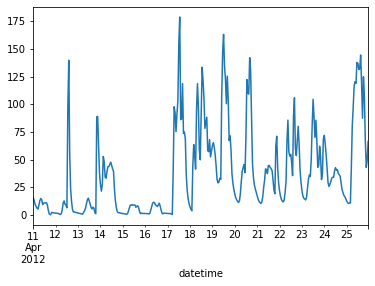

In [33]:
df_output.loc[98].SUEWS.loc['2012-04-11':'2012-04-25'].resample('1h').mean().QE.plot()